In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Loading the Dataset

In [2]:
import re

def clean_text(text):
    # 한글과 공백만 남기고 나머지 문자 제거
    cleaned_text = re.sub(r'[^가-힣\s]', '', text)
    return cleaned_text.strip()

def load_data(data_name):
    """
    input: (str)
    => data_name: name of raw text csv
    """
    data = pd.read_csv(data_name,encoding='utf-8', index_col=0)

    data = data[~data['text'].str.match('^\d+$')]
    data = data[~data['text'].str.contains('\u200b')]

    data['text'] = data['text'].apply(clean_text)
    data = data[data['text'] != '']
    data.reset_index(drop=True, inplace=True)

    return data

data_name = 'labeling_0927.csv'
data = load_data(data_name)
docs = data['text']
classes = data['label']
data.head()

,text,label
0,남은 시간,0
1,리뷰,0
2,개,0
3,종 택,0
4,팩 외 팩 김나운 진꼬리곰탕,0


In [3]:
docs = data['text']
classes = data['label']

# train / test 분할 (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(docs, classes, test_size=0.2, random_state=42)

def preprocessing(text):
    """
    input: (pandas.Series.series or list)
    output: (tokenizer, padded_X)
    """
    token = Tokenizer()
    token.fit_on_texts(text)
    x = token.texts_to_sequences(text)
    padded_x = pad_sequences(x, 16)
    return token, padded_x

token, padded_x = preprocessing(X_train)

In [4]:
def pre_pad(X_train, token):
    x = token.texts_to_sequences(X_train)
    padded_x = pad_sequences(x, 16)
    return padded_x

def pre_y(y_train):
    y_train_one_hot = pd.get_dummies(y_train)
    return y_train_one_hot

X_test_pad = pre_pad(X_test, token)
y_test_one_hot = pre_y(y_test)

# Training GRU Model

In [5]:
def make_gru_model(padded_x, y_train, padded_x_test, y_test):
    y_train_one_hot = pd.get_dummies(y_train)
    y_test_one_hot = pd.get_dummies(y_test)

    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=max(padded_x.flatten())+1, output_dim=16, input_length=16))

    # GRU layer
    model.add(GRU(32, return_sequences=False))

    # Dense layer
    model.add(Dense(16, activation='relu'))

    # Output layer for 5-class classification
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    epochs = 100
    history = model.fit(
        padded_x,
        y_train_one_hot,
        epochs=epochs,
        validation_data=(X_test_pad, y_test_one_hot),
        callbacks=[early_stopping]
    )

    return model, history

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7285 - loss: 1.1423 - val_accuracy: 0.8354 - val_loss: 0.4647
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9062 - loss: 0.3064 - val_accuracy: 0.9243 - val_loss: 0.2535
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9515 - loss: 0.1430 - val_accuracy: 0.9552 - val_loss: 0.1965
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9808 - loss: 0.0776 - val_accuracy: 0.9628 - val_loss: 0.1711
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9853 - loss: 0.0605 - val_accuracy: 0.9628 - val_loss: 0.1757
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9907 - loss: 0.0406 - val_accuracy: 0.9615 - val_loss: 0.1757
Epoch 7/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9935 - loss: 0.0275 - val_accuracy: 0.9666 - val_loss: 0.1738
Epoch 8/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9915 - loss: 0.0315 -

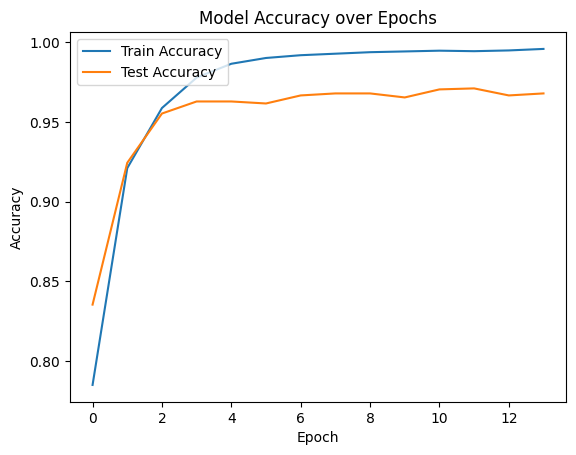

In [6]:
model, history = make_gru_model(padded_x, y_train, X_test_pad, y_test)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

plot_accuracy(history)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 16, 16)              │         109,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           4,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 345,761 (1.32 MB)

 Trainable params: 115,253 (450.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 230,508 (900.43 KB)

# Evaluating Model

In [9]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

y_test_pred = model.predict(X_test_pad)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_test_pred_class))
print("Precision:", precision_score(y_test, y_test_pred_class, average='weighted'))
print("Recall:", recall_score(y_test, y_test_pred_class, average='weighted'))
print("F1 Score:", f1_score(y_test, y_test_pred_class, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_class))


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Accuracy: 0.9627994955863808
Precision: 0.9622074240518826
Recall: 0.9627994955863808
F1 Score: 0.960858738191153

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1266
           1       0.93      0.56      0.70        50
           2       0.88      0.95      0.91        92
           3       0.80      0.73      0.76        48
           4       0.96      0.94      0.95       130

    accuracy                           0.96      1586
   macro avg       0.91      0.83      0.86      1586
weighted avg       0.96      0.96      0.96      1586



In [10]:
model.save('clf_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)